# Learning to select the fastest `select_k` algorithm

Using the dataset of algorithm times generated by `generate_dataset.py` here - this notebook trains a
DecisionTree model that will predict the fastest algorithm based of the number of rows and columns in the input
array, as well as the `k` value.

In [1]:
import sklearn.tree
import pandas
from collections import defaultdict
import numpy as np

In [2]:
feature_names = ["k", "rows", "cols"]
df = pandas.read_csv("./select_k_times.csv")
df = df[df.algo != "AUTO"]
df

,algo,k,row,col,time
0,RADIX,1,1,1024,0.000081
1,WARPSORT,1,1,1024,0.000087
2,BLOCK,1,1,1024,0.000062
3,RADIX,1,1,2048,0.000083
4,WARPSORT,1,1,2048,0.000087
...,...,...,...,...,...
21595,WARPSORT,2848,175,28588,inf
21596,BLOCK,2848,175,28588,inf
21597,RADIX,28,32856,86052,0.082225
21598,WARPSORT,28,32856,86052,0.021657


In [3]:
# group the dataframe by the input features
feature_algo_time = defaultdict(list)
for row in df.itertuples():
    feature_algo_time[(row.k, row.row, row.col)].append((row.algo, row.time))

# get the features (x), labels (y) and sample_weights from the grouped times
X, y, weights = [], [], []
for feature, algo_times in feature_algo_time.items():    
    # figure out the fastest algorithm for this set of features
    algo_times = sorted(algo_times, key = lambda x: x[1])
    best_algo, best_time = algo_times[0]

    # set the sample_weight to the absolute speed increase above the 
    # time of the next fastest algorithm. the idea here is that
    # we really want to capture the 2x or 10x speedups - but 
    # the 1% speedups might just be noise (and this is especially
    # true for the faster runs)
    second_best_time = algo_times[1][1]
    # sample_weight = min((second_best_time / best_time) - 1, 10)
    sample_weight = min((second_best_time - best_time), 10)
    
    X.append(feature)
    y.append(best_algo)
    weights.append(sample_weight)
    
X, y, weights = np.array(X), np.array(y), np.array(weights)

# break down into a train test 
train_test_sets = sklearn.model_selection.train_test_split(X, y, weights, test_size=0.15, random_state=1)
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_sets

X_train.shape, X_test.shape

((6120, 3), (1080, 3))

In [4]:
model = sklearn.tree.DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)
model.fit(X_train, y_train, weights_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)

In [5]:
model.score(X_train, y_train, weights_train)

0.9998911884063653

In [6]:
model.score(X_test, y_test, weights_test)

0.9999179593475171

In [7]:
# print(sklearn.tree.export_text(model, feature_names=["k", "rows", "cols"]))

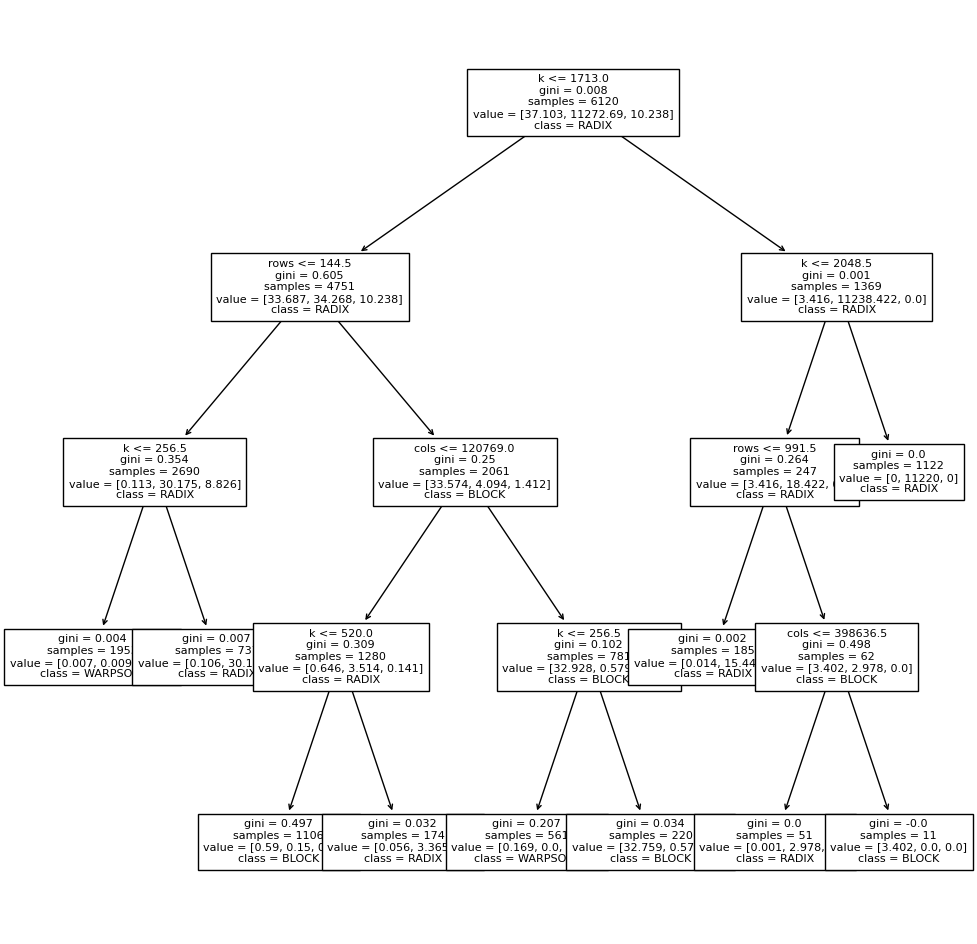

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
viz = sklearn.tree.plot_tree(model, fontsize=8, label='all', class_names=model.classes_, feature_names=["k", "rows", "cols"], impurity=True)

In [9]:
def convert_model_to_code(model):
    classes = model.classes_
    tree = model.tree_
    feature_names = ["k", "rows", "cols"]
    
    def _get_label(nodeid):
        """ returns the most frequent class name for the node """
        return classes[np.argsort(tree.value[nodeid, 0])[-1]]
    
    def _is_leaf_node(nodeid):
        """ returns whether or not the node is a leaf node in the tree"""
        # negative values here indicate we're a leaf
        if tree.feature[nodeid] < 0:
            return True
        
        # some nodes have both branches with the same label, combine those
        left, right = tree.children_left[nodeid], tree.children_right[nodeid]    
        if (_is_leaf_node(left) and 
            _is_leaf_node(right) and 
            _get_label(left) == _get_label(right)):
            return True
    
        return False
    
    code = []
    def _convert_node(nodeid, indent):
        if _is_leaf_node(nodeid):
            # we're a leaf node, just output the label of the most frequent algorithm
            class_name = _get_label(nodeid)
            code.append(" " * indent + f"return select_method::{class_name};")
        else:             
            feature = feature_names[tree.feature[nodeid]]
            threshold = int(np.floor(tree.threshold[nodeid]))
            code.append(" " * indent + f"if ({feature} > {threshold}) " + "{")
            _convert_node(tree.children_right[nodeid], indent + 2)
            code.append(" " * indent + "} else {")
            _convert_node(tree.children_left[nodeid], indent + 2)
            code.append(" " * indent + "}")
    
    code.append("inline select_method choose_select_k_algorithm(size_t rows, size_t cols, int k)")
    code.append("{")
    _convert_node(0, indent=2)
    code.append("}")
    return "\n".join(code)

code = convert_model_to_code(model)
print(code)

inline select_method choose_select_k_algorithm(size_t rows, size_t cols, int k)
{
  if (k > 1713) {
    if (k > 2048) {
      return select_method::RADIX;
    } else {
      if (rows > 991) {
        if (cols > 398636) {
          return select_method::BLOCK;
        } else {
          return select_method::RADIX;
        }
      } else {
        return select_method::RADIX;
      }
    }
  } else {
    if (rows > 144) {
      if (cols > 120769) {
        if (k > 256) {
          return select_method::BLOCK;
        } else {
          return select_method::WARPSORT;
        }
      } else {
        if (k > 520) {
          return select_method::RADIX;
        } else {
          return select_method::BLOCK;
        }
      }
    } else {
      if (k > 256) {
        return select_method::RADIX;
      } else {
        return select_method::WARPSORT;
      }
    }
  }
}


In [10]:
# also update the source code in raft/matrix/detail/select_k.cuh
import pathlib
select_k_path = pathlib.Path.cwd() / ".." / ".." / ".." / "include" / "raft" / "matrix" / "detail" / "select_k.cuh"
source_lines = open(select_k_path.resolve()).read().split("\n")

# figure out the location of the code snippet in the file, and splice it in
code_lines = code.split("\n")
first_line = source_lines.index(code_lines[0])
last_line =  source_lines.index(code_lines[-1], first_line)
new_source = source_lines[:first_line] + code_lines + source_lines[last_line+1:]

open(select_k_path.resolve(), "w").write("\n".join(new_source))

5290